Il progetto si propone di analizzare un dataset composto da diverse caratteristiche delle tracce musicali, inclusi elementi quali la danceability, l'energy, l'acousticness, l'instrumentalness, la liveness, e la speechiness. Attraverso tecniche di EDA e visualizzazione, come istogrammi, box plot e pair plots, esploriamo la distribuzione e le relazioni tra queste variabili. L'obiettivo è identificare correlazioni che possono offrire intuizioni sulle dinamiche di successo di una traccia.
Inoltre, il progetto si avvale della regressione logistica per prevedere la probabilità che una traccia appaia nelle classifiche di Spotify. Un altro obiettivo è prevedere l'artista futuro dati li ascolti precedenti. Successivamente andrò a prevedere il brano che potrà trovarsi nella playlist di spotify, sia con il regressore logistico che con Naive Bayes e farò un confronto tra i due modelli per bedere chi ha un accuracy migliore.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from plotly.offline import iplot
import plotly.express as px
from sklearn.linear_model import LogisticRegression
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("spotify-2023.csv", encoding='latin1')

In [3]:
# Verifica la presenza di valori mancanti
missing_values = df.isnull().sum()

# Rimuovi le righe con valori mancanti (opzionale, basato sulla tua decisione)
df_clean = df.dropna()

# Verifica e rimuovi i duplicati
df_clean = df_clean.drop_duplicates()

# Controlla i tipi di dati per assicurarti che siano coerenti con quello che ti aspetti
data_types = df_clean.dtypes

# Se necessario, converti i tipi di dati, ad esempio assicurandoti che 'streams' sia numerico
df_clean['streams'] = pd.to_numeric(df_clean['streams'], errors='coerce')

# Nuovo controllo per valori mancanti dopo la conversione, poiché la conversione può introdurre nuovi NaN
missing_values_after_conversion = df_clean.isnull().sum()

# Puoi scegliere di rimuovere nuovamente le righe con valori mancanti dopo la conversione, se necessario
df_clean = df_clean.dropna()

In [4]:
# Visualizza il DataFrame pulito e i tipi di dati finali
df_clean.head()

track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts      streams  in_apple_playlists  ...  bpm key   mode  \
0                147  141381703.0                  43  ...  125   B  Major   
1                 48  133716286.0                  48  ...   92  C#  Major   
2                113  140003974.0                  94  ...  138   F  Major   
3                100  800840817.0                 116  ...  170   A  Major   
4                 50  303236322.0                  84  ...  144   A  Minor   

  danceability_%  valence_% energy_% acousticness_%  instrumentalness_%  \
0             80         89       83             31                   0   
1             71         61       74              7                   0   
2             51         32       53             17                   0   
3             55         58       72             11                   0   
4             65         23       80             14                  63   

   liveness_%  speechiness_%  
0           8              4  
1          10              4  
2          31              6  
3          11             15  
4          11              6  

[5 rows x 24 columns]

In [5]:
df_clean.shape

(816, 24)

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 816 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            816 non-null    object 
 1   artist(s)_name        816 non-null    object 
 2   artist_count          816 non-null    int64  
 3   released_year         816 non-null    int64  
 4   released_month        816 non-null    int64  
 5   released_day          816 non-null    int64  
 6   in_spotify_playlists  816 non-null    int64  
 7   in_spotify_charts     816 non-null    int64  
 8   streams               816 non-null    float64
 9   in_apple_playlists    816 non-null    int64  
 10  in_apple_charts       816 non-null    int64  
 11  in_deezer_playlists   816 non-null    object 
 12  in_deezer_charts      816 non-null    int64  
 13  in_shazam_charts      816 non-null    object 
 14  bpm                   816 non-null    int64  
 15  key                   816 no

In [7]:
df_clean.describe()

artist_count  released_year  released_month  released_day  \
count    816.000000     816.000000      816.000000    816.000000   
mean       1.568627    2018.517157        6.024510     13.712010   
std        0.876522      10.701973        3.570415      9.294719   
min        1.000000    1930.000000        1.000000      1.000000   
25%        1.000000    2021.000000        3.000000      5.000000   
50%        1.000000    2022.000000        5.000000     13.000000   
75%        2.000000    2022.000000        9.000000     22.000000   
max        8.000000    2023.000000       12.000000     31.000000   

       in_spotify_playlists  in_spotify_charts       streams  \
count            816.000000         816.000000  8.160000e+02   
mean            4852.316176          11.736520  4.689858e+08   
std             7745.565488          18.624555  5.231267e+08   
min               31.000000           0.000000  2.762000e+03   
25%              829.000000           0.000000  1.342848e+08   
50%             2037.500000           3.000000  2.638368e+08   
75%             4890.750000          16.000000  6.011986e+08   
max            52898.000000         147.000000  3.562544e+09   

       in_apple_playlists  in_apple_charts  in_deezer_charts         bpm  \
count          816.000000       816.000000        816.000000  816.000000   
mean            60.215686        49.534314          2.454657  122.580882   
std             74.953565        49.570536          5.399650   28.188643   
min              0.000000         0.000000          0.000000   65.000000   
25%             12.000000         6.000000          0.000000   99.000000   
50%             32.000000        34.500000          0.000000  120.000000   
75%             78.250000        84.000000          2.000000  141.250000   
max            532.000000       275.000000         45.000000  206.000000   

       danceability_%   valence_%    energy_%  acousticness_%  \
count      816.000000  816.000000  816.000000      816.000000   
mean        67.409314   51.172794   64.356618       26.333333   
std         14.688808   23.620742   16.116646       25.477606   
min         23.000000    4.000000   14.000000        0.000000   
25%         57.000000   32.000000   53.000000        5.000000   
50%         70.000000   51.000000   66.000000       17.000000   
75%         79.000000   70.000000   76.000000       41.000000   
max         96.000000   97.000000   97.000000       97.000000   

       instrumentalness_%  liveness_%  speechiness_%  
count          816.000000  816.000000     816.000000  
mean             1.678922   18.170343      10.535539  
std              8.772508   13.550239      10.222852  
min              0.000000    3.000000       2.000000  
25%              0.000000   10.000000       4.000000  
50%              0.000000   12.000000       6.000000  
75%              0.000000   24.000000      12.000000  
max             91.000000   97.000000      64.000000

Mostriamo la frequenza di ogni chiave musicale nel dataset. Il grafico rappresenta:
L'asse x rappresenta le diverse chiavi musicali trovate nei dati.
L'asse y mostra il numero di volte che ciascuna chiave musicale appare nel dataset.

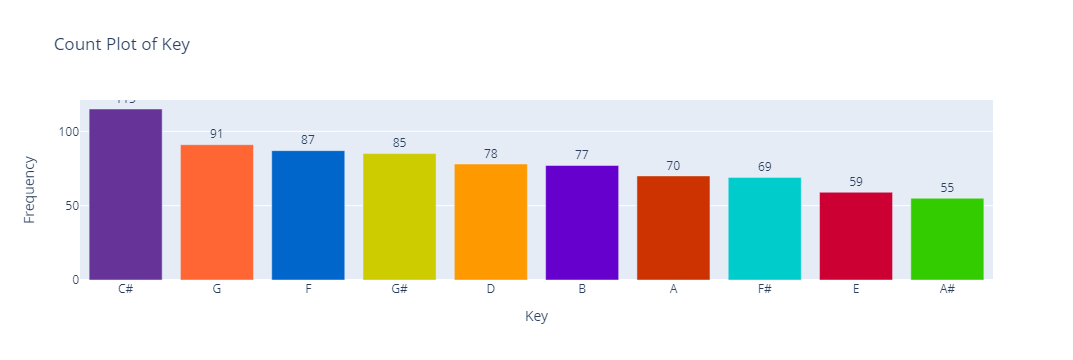

In [8]:
#Generiamo una serie di conteggi per ciascuna chiave e quindi reimpostiamo l'indice per convertirlo in un DataFrame
key_counts = df_clean['key'].value_counts().reset_index()
key_counts.columns = ['Musical Key', 'Count']

colors = ['#639', '#f63', '#06c', '#cc0', '#f90', '#60c', '#c30', '#0cc', '#c03', '#3c0']

fig = px.bar(
    key_counts.head(10),  # Assuming we only want the top 10 keys
    x='Musical Key',
    y='Count',
    text='Count',
    color='Musical Key',
    color_discrete_sequence=colors[:len(key_counts.head(10))],  # Apply the colors to the bars
    title='Count Plot of Key'
)

# Personalizza il layout per migliorare la leggibilità
fig.update_layout(
    xaxis_title='Key',
    yaxis_title='Frequency',
    showlegend=False
)
# Personalizza il testo sopra le barre
fig.update_traces(texttemplate='%{text}', textposition='outside')


fig.show()

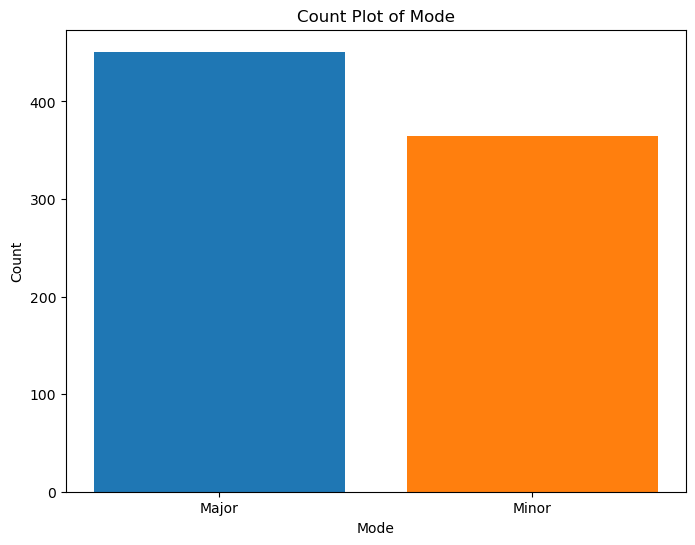

In [9]:
mode_counts = df_clean['mode'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(mode_counts.index, mode_counts.values, color=["#1f77b4", "#ff7f0e"])


plt.title('Count Plot of Mode')
plt.xlabel('Mode')
plt.ylabel('Count')

plt.show()

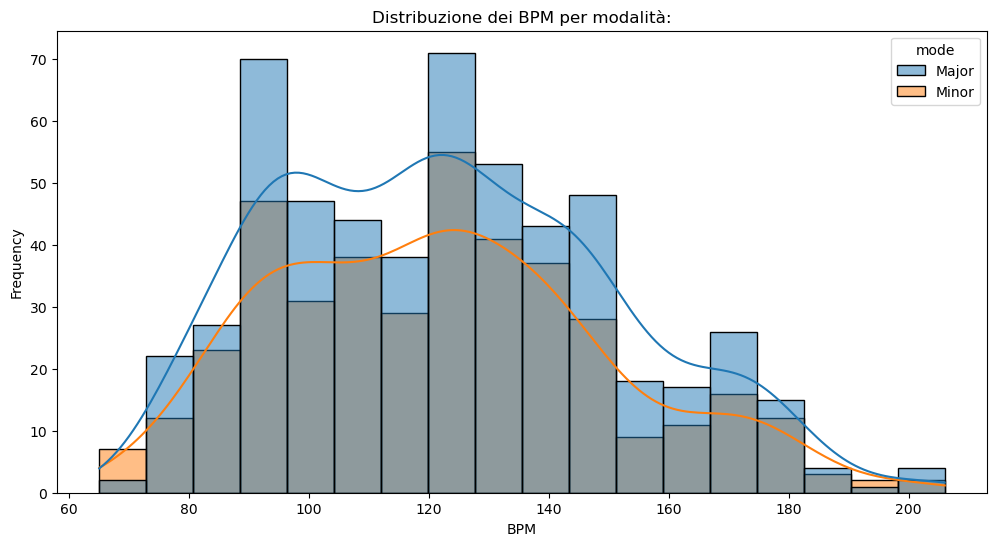

In [10]:
# Distribuzione dei BPM per modalità:
plt.figure(figsize=(12, 6))
sns.histplot(x='bpm', data=df, hue='mode', kde=True)
plt.title('Distribuzione dei BPM per modalità:')
plt.xlabel('BPM')
plt.ylabel('Frequency')
plt.show()

Artisti con maggior numero di canzoni

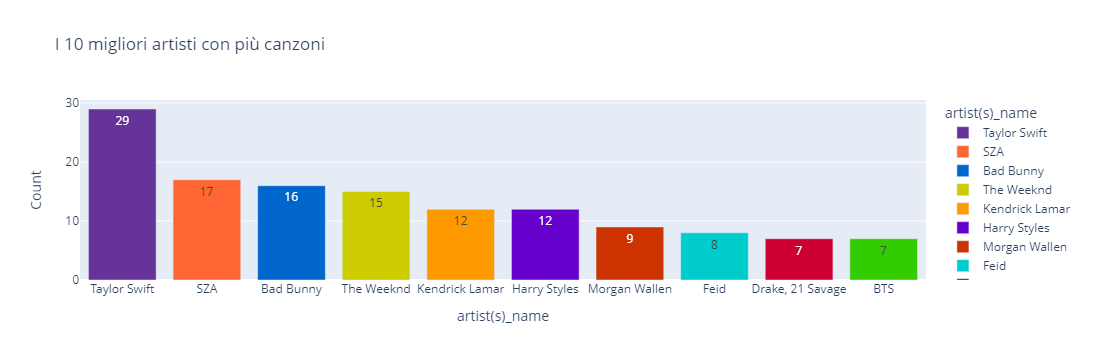

In [11]:
# Preparazione dei dati
top_artists = df_clean['artist(s)_name'].value_counts().head(10)

# Definizione della lista di colori
colors = ['#639', '#f63', '#06c', '#cc0', '#f90', '#60c', '#c30', '#0cc', '#c03', '#3c0']

fig = px.bar(top_artists,
             text_auto=True,
             color=top_artists.index,
             color_discrete_sequence=colors, 
             labels={'index': "Artist Names", 'value': "Count"},
             title='I 10 migliori artisti con più canzoni')

fig.show()

Traccia con maggior numero di streams

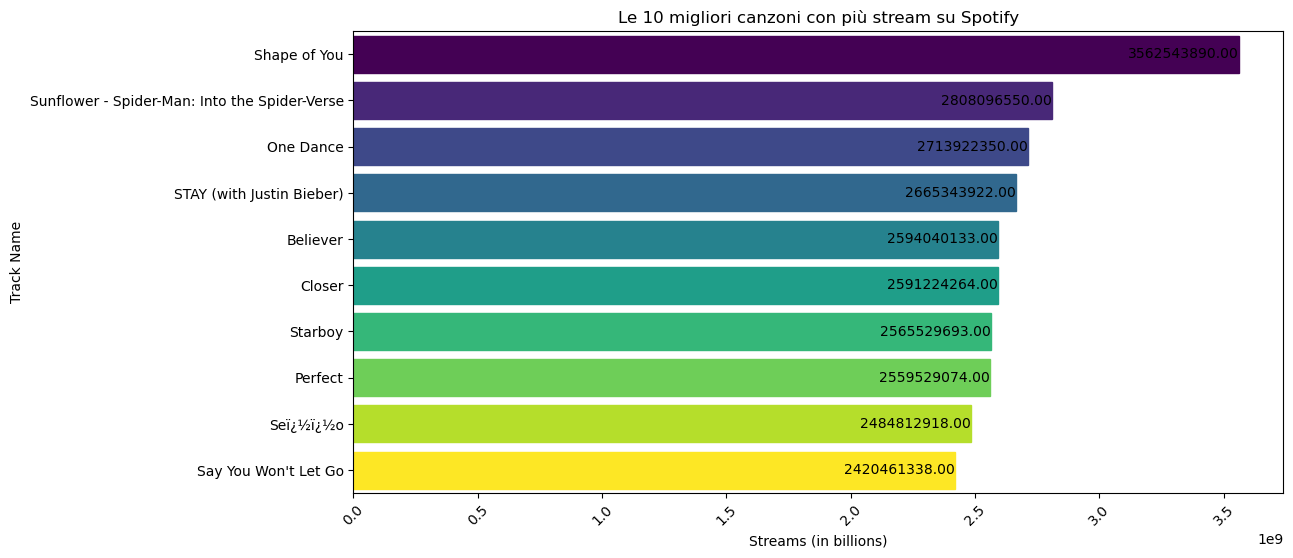

In [12]:
# Preparazione dei dati
top_spotify_streams = df_clean[['track_name', 'artist(s)_name', 'streams']].sort_values(by='streams', ascending=False).head(10)

# Creazione del grafico utilizzando seaborn per la barra, senza specificare colori in questo passaggio
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=top_spotify_streams, x='streams', y='track_name', color='lightblue')  # Color di base

# Generazione di una lista di colori dalla mappa colore 'viridis'
colors = plt.cm.viridis(np.linspace(0, 1, len(top_spotify_streams)))

# Assegnazione dei colori a ogni barra manualmente
for i, bar in enumerate(barplot.patches):
    bar.set_color(colors[i])  # Assegnazione del colore dalla lista

# Aggiunta del testo sulle barre per mostrare il valore dei 'streams'
for index, value in enumerate(top_spotify_streams['streams']):
    plt.text(value, index, f'{value:.2f}', color='black', va='center', ha='right')

plt.xlabel('Streams (in billions)')
plt.ylabel('Track Name')
plt.title('Le 10 migliori canzoni con più stream su Spotify')
plt.xticks(rotation=45)
plt.show()

In [13]:
top_spotify_streams

track_name  \
179                                   Shape of You   
41   Sunflower - Spider-Man: Into the Spider-Verse   
162                                      One Dance   
84                       STAY (with Justin Bieber)   
140                                       Believer   
725                                         Closer   
48                                         Starboy   
138                                        Perfect   
693                                      Seï¿½ï¿½o   
324                           Say You Won't Let Go   

                   artist(s)_name       streams  
179                    Ed Sheeran  3.562544e+09  
41          Post Malone, Swae Lee  2.808097e+09  
162           Drake, WizKid, Kyla  2.713922e+09  
84   Justin Bieber, The Kid Laroi  2.665344e+09  
140               Imagine Dragons  2.594040e+09  
725      The Chainsmokers, Halsey  2.591224e+09  
48          The Weeknd, Daft Punk  2.565530e+09  
138                    Ed Sheeran  2.559529e+09  
693  Shawn Mendes, Camila Cabello  2.484813e+09  
324                  James Arthur  2.420461e+09

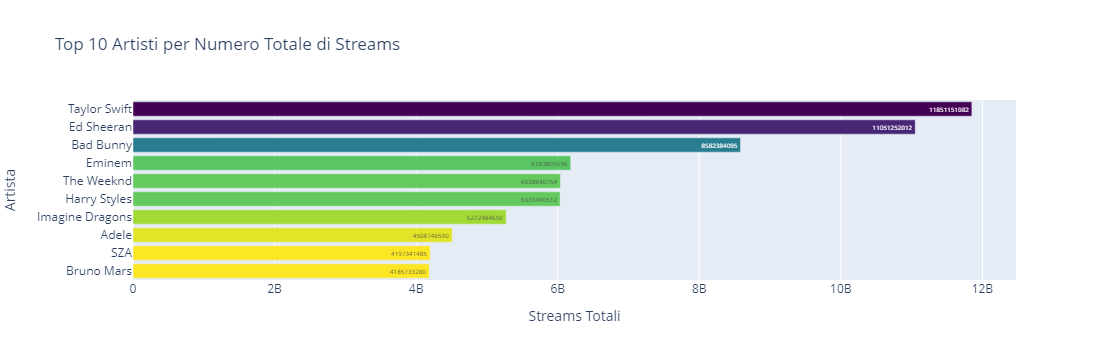

In [14]:
#Confronto tra Categorie: Se ci sono colonne che rappresentano categorie (come generi musicali, artisti, o regioni geografiche), potresti esaminare come i dati di streaming differiscono tra queste categorie. Grafici a barre o box plot possono essere utili per questo scopo."
import plotly.graph_objs as go

# Aggregazione dei dati di streaming per artista
artist_streams = df_clean.groupby('artist(s)_name')['streams'].sum().reset_index()

# Ordinamento dei dati per ottenere gli artisti per streams
artist_streams_sorted = artist_streams.sort_values('streams', ascending=True)  # Inverti l'ordine a 'ascending=True'

# Selezione dei primi 10 artisti
top_artists = artist_streams_sorted.tail(10)  # Utilizza tail(10) invece di head(10) per ottenere gli ultimi 10 artisti

# Creazione del grafico a barre con Plotly
bar_data = go.Bar(
    x=top_artists['streams'],
    y=top_artists['artist(s)_name'],
    orientation='h',  # Orientazione orizzontale delle barre
    text=top_artists['streams'],  # Testo da mostrare sulle barre
    textposition='auto',  # Posizionamento automatico del testo sulle barre
    marker=dict(
        color=top_artists['streams'],  # Colore delle barre basato sul numero di stream
        colorscale='Viridis',  # Scala di colori
        reversescale=True  # Inverti la scala dei colori per una migliore visualizzazione
    )
)

layout = go.Layout(
    title='Top 10 Artisti per Numero Totale di Streams',
    xaxis=dict(title='Streams Totali'),
    yaxis=dict(title='Artista')
)

fig = go.Figure(data=[bar_data], layout=layout)
iplot(fig)

Qual'è l'artista con la più altra prob di avere maggiori stream?

In [61]:
# Aggregazione dei dati per artista
top_artists = df_clean.groupby('artist(s)_name').agg({
    'streams': 'sum',
    'danceability_%': 'mean',
    'valence_%': 'mean',
    'energy_%': 'mean',
    'acousticness_%': 'mean', 
    'instrumentalness_%': 'mean', 
    'liveness_%': 'mean', 
    'speechiness_%': 'mean'
}).reset_index()

# Conta il numero di tracce per ogni artista
track_counts = df_clean['artist(s)_name'].value_counts().reset_index()
track_counts.columns = ['artist(s)_name', 'total_tracks']

# Unisci il conteggio delle tracce al DataFrame top_artists
top_artists = pd.merge(top_artists, track_counts, on='artist(s)_name', how='left')

# Calcola gli stream medi per traccia come proxy del successo per traccia
top_artists['popularity_score'] = top_artists['streams'] / top_artists['total_tracks']

In [62]:
# Preparazione dei dati per la regressione lineare
X = top_artists.drop(['artist(s)_name', 'streams', 'popularity_score', 'total_tracks'], axis=1)
y = top_artists['popularity_score'].rank(pct=True)

# Standardizzazione dei dati
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [63]:
# Definizione e addestramento del modello di regressione lineare
model = LinearRegression()
model.fit(X_scaled, y)

LinearRegression()

In [64]:
# Previsione del "popularity score"
top_artists['predicted_popularity_score'] = model.predict(X_scaled)

# Seleziona i top 5 artisti basati sulla probabilità di essere popolare
top_5_artists = top_artists.nlargest(5, 'predicted_popularity_score')

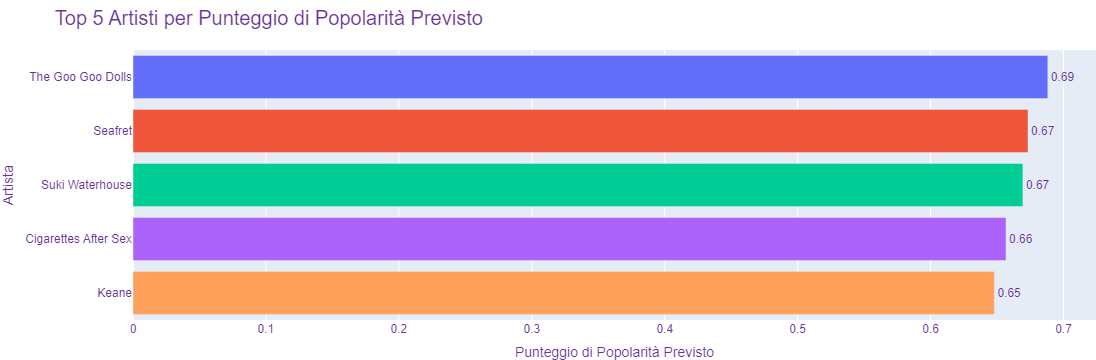

In [65]:
# Creazione del grafico con Plotly Express
fig = px.bar(top_5_artists,
             y='artist(s)_name',
             x='predicted_popularity_score',
             text='predicted_popularity_score',
             color='artist(s)_name',  # Colora le barre in base al nome dell'artista
             orientation='h',  # Orientamento orizzontale delle barre
             labels={'predicted_popularity_score': 'Punteggio di Popolarità Previsto', 'artist(s)_name': 'Artista'},
             title='Top 5 Artisti per Punteggio di Popolarità Previsto')

# Personalizzazione ulteriore del grafico
fig.update_layout(showlegend=False,
                  title_font_size=20,
                  font=dict(family="Arial, sans-serif", size=12, color="RebeccaPurple"))

# Migliora la formattazione del testo sui dati per meglio leggere i valori
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

# Aggiustamento del layout del grafico per evitare il taglio del testo
fig.update_layout(margin=dict(t=50, l=0, r=0, b=0))

# Mostra il grafico
fig.show()

In [66]:
from sklearn.metrics import root_mean_squared_error

# Calcolo delle predizioni sul dataset
y_pred = model.predict(X_scaled)

# Calcolo di RMSE utilizzando la funzione root_mean_squared_error
rmse = root_mean_squared_error(y, y_pred)

print(f"RMSE: {rmse}")

RMSE: 0.2818451071865988


Mostra la frequenza dei dati di streaming in intervalli specifici. L'uso dell'opzione kde=True aggiunge una stima della densità del kernel al grafico, fornendo una linea liscia che rappresenta la distribuzione.

In [22]:
# Calcolo delle statistiche descrittive per la colonna 'streams'
mean = df_clean['streams'].mean()
median = df_clean['streams'].median()
variance = df_clean['streams'].var()
std_dev = df_clean['streams'].std()
percentiles = df_clean['streams'].quantile([0.25, 0.5, 0.75])

# Stampa delle statistiche
print('Calcolo delle statistiche descrittive per la colonna streams\n')
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Variance: {variance}")
print(f"Standard Deviation: {std_dev}")
print(f"25th Percentile: {percentiles[0.25]}")
print(f"50th Percentile (Median): {percentiles[0.5]}")
print(f"75th Percentile: {percentiles[0.75]}")

Calcolo delle statistiche descrittive per la colonna streams

Mean: 468985764.4080882
Median: 263836779.5
Variance: 2.7366159469724688e+17
Standard Deviation: 523126748.2142802
25th Percentile: 134284821.0
50th Percentile (Median): 263836779.5
75th Percentile: 601198591.25


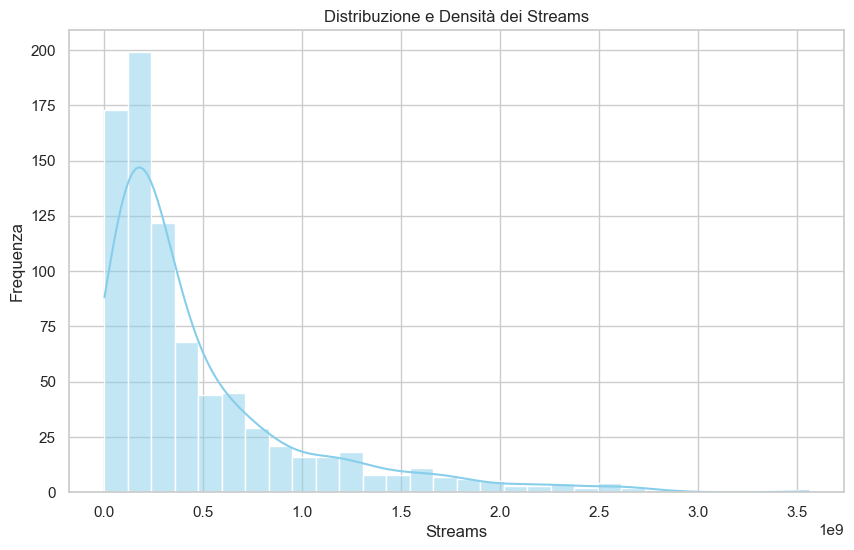

In [23]:
# Configurazione dello stile dei grafici
sns.set(style="whitegrid")

# Creazione di un grafico a distribuzione (istogramma) per 'streams' con KDE
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['streams'], kde=True, bins=30, color='skyblue')
plt.title('Distribuzione e Densità dei Streams')
plt.xlabel('Streams')
plt.ylabel('Frequenza')
plt.show()

Trend Temporali: Se il dataset include una colonna temporale (come date o timestamp), potrei analizzare come i dati di streaming variano nel tempo. Grafici lineari o di serie temporali possono aiutarti a identificare tendenze, stagionalità o pattern ricorrenti.

In [24]:
# Assicurati che tutte le colonne siano nel tipo di dati corretto
df_clean['released_year'] = df_clean['released_year'].astype(int)
df_clean['released_month'] = df_clean['released_month'].astype(int)
df_clean['released_day'] = df_clean['released_day'].astype(int)

# Usa una funzione lambda per combinare le colonne in una stringa di data
df_clean['released_date'] = df_clean.apply(lambda row: f"{row['released_year']}-{row['released_month']:02d}-{row['released_day']:02d}", axis=1)

# Converti la stringa di data in datetime
df_clean['released_date'] = pd.to_datetime(df_clean['released_date'])

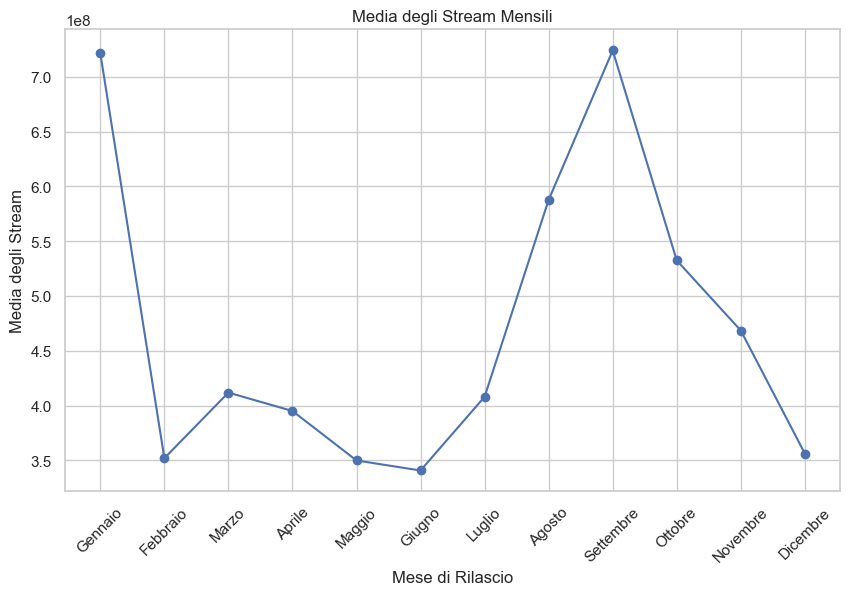

In [25]:
# Calcolo degli stream mensili medi
monthly_streams = df_clean.groupby(df_clean['released_date'].dt.month)['streams'].mean()

# Grafico delle tendenze mensili
monthly_streams.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Media degli Stream Mensili')
plt.xlabel('Mese di Rilascio')
plt.ylabel('Media degli Stream')
plt.xticks(range(1, 13), ['Gennaio', 'Febbraio', 'Marzo', 'Aprile', 'Maggio', 'Giugno', 'Luglio', 'Agosto', 'Settembre', 'Ottobre', 'Novembre', 'Dicembre'], rotation=45)
plt.grid(True)
plt.show()

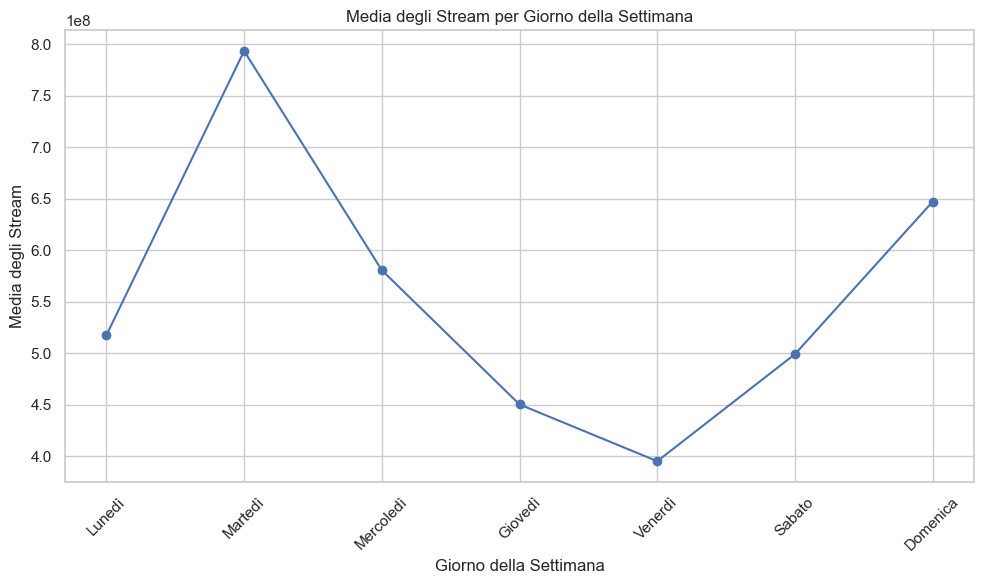

In [26]:
# Aggiunta di una colonna giorno della settimana
df_clean['released_weekday'] = df_clean['released_date'].dt.day_name()

# Ordinamento dei giorni della settimana per assicurarsi che il grafico li visualizzi nell'ordine corretto
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_clean['released_weekday'] = pd.Categorical(df_clean['released_weekday'], categories=ordered_days, ordered=True)

# Calcolo degli stream medi per giorno della settimana con l'opzione observed specificata
weekday_streams = df_clean.groupby('released_weekday', observed=True)['streams'].mean()

# Ordina la serie in base al giorno della settimana
weekday_streams = weekday_streams.reindex(ordered_days)

# Inizializzazione della figura
plt.figure(figsize=(10, 6))

# Creazione del grafico
weekday_streams.plot(kind='line', marker='o')
plt.title('Media degli Stream per Giorno della Settimana')
plt.ylabel('Media degli Stream')
plt.xlabel('Giorno della Settimana')
# Assicurati di avere l'elenco corretto dei nomi dei giorni in italiano, se il tuo dataframe è in italiano
plt.xticks(range(len(ordered_days)), ['Lunedì', 'Martedì', 'Mercoledì', 'Giovedì', 'Venerdì', 'Sabato', 'Domenica'], rotation=45)
plt.grid(True)
plt.tight_layout()  # Aggiunge automaticamente spazio sufficiente per contenere le etichette
plt.show()

In [27]:
import warnings
# Ignora tutti i UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

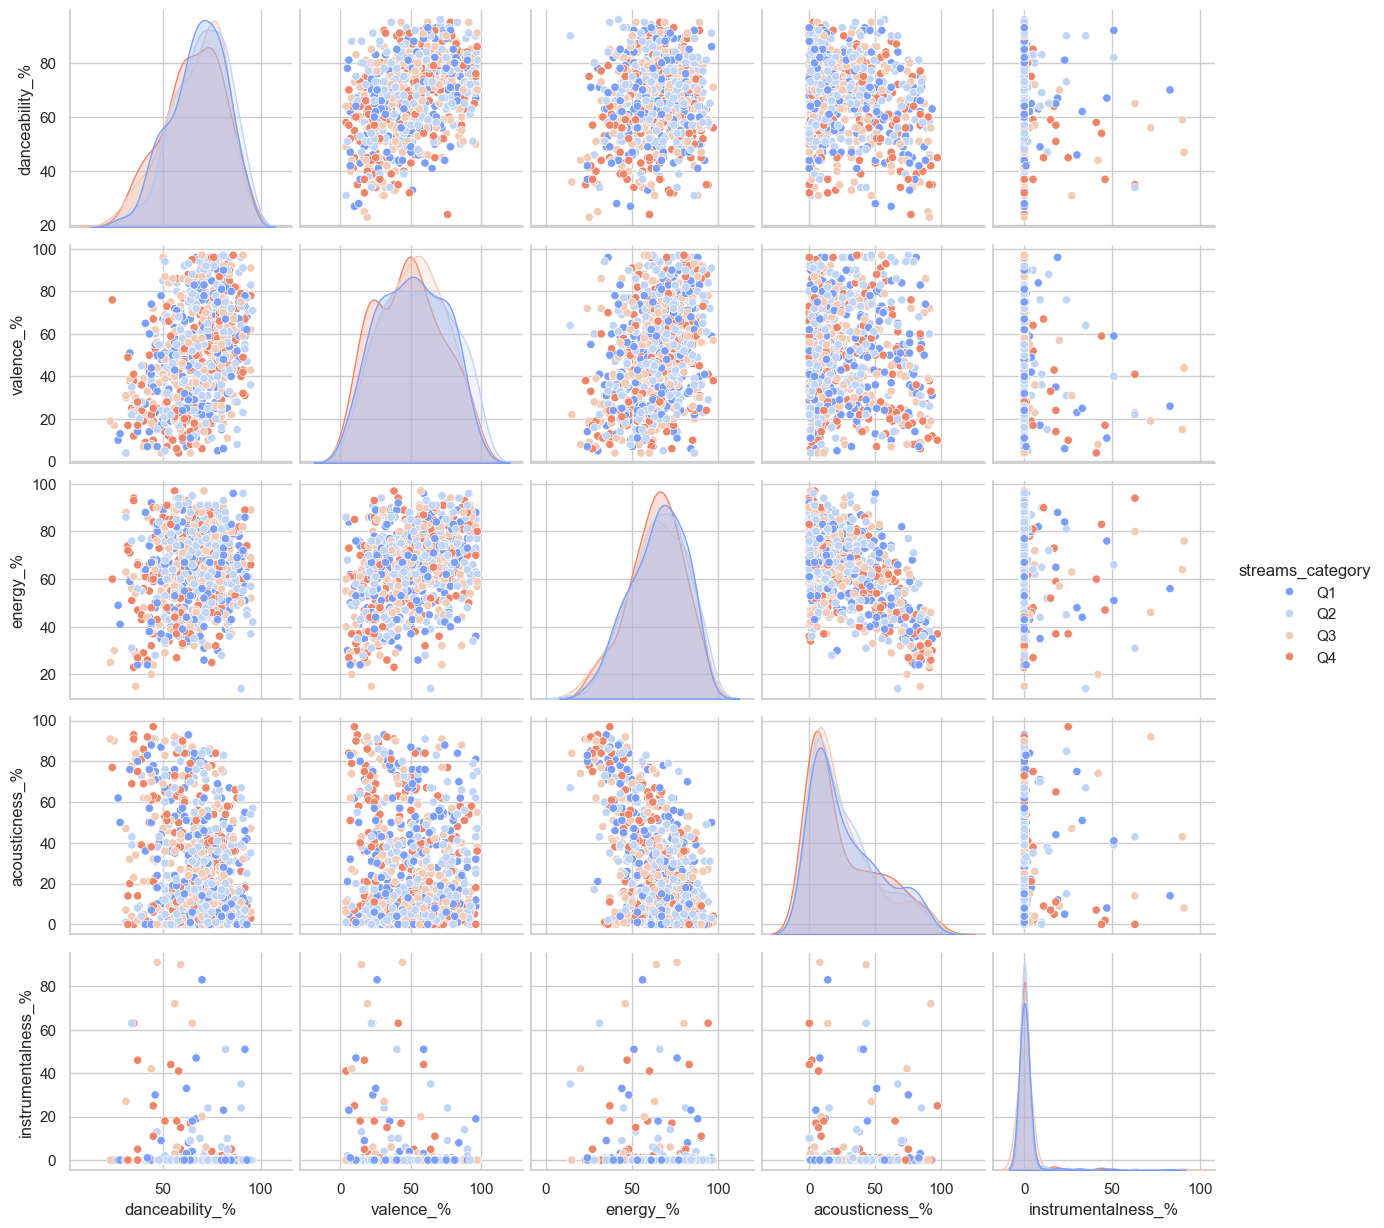

In [28]:
# Categorizza 'streams' in quartili
df_clean['streams_category'] = pd.qcut(df_clean['streams'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

columns_for_pairplot = [
    'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'streams_category'
]

# Esegui il pairplot usando 'streams_category' come variabile di hue
sns.pairplot(df_clean[columns_for_pairplot], hue='streams_category', palette="coolwarm")

plt.show()

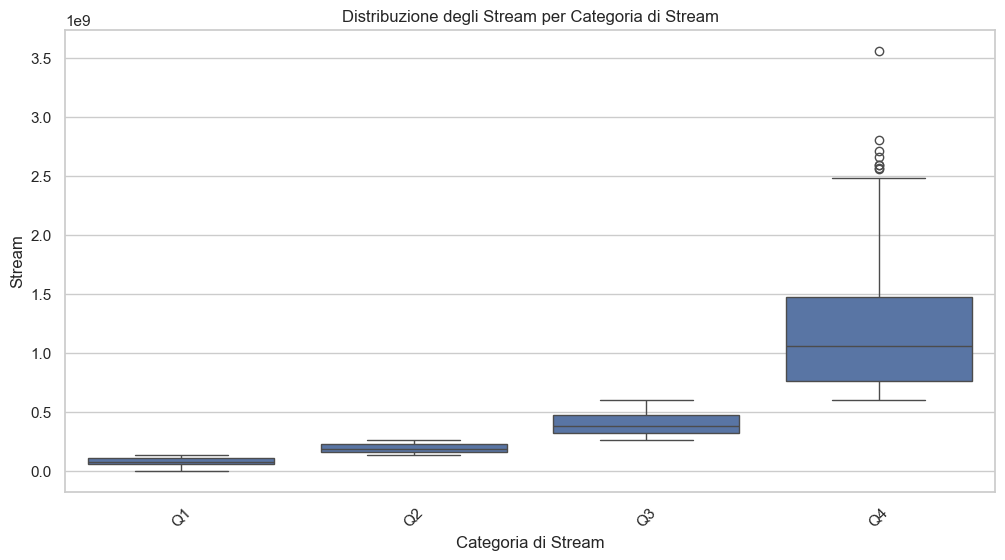

In [29]:
# Box plot per 'streams_category'
plt.figure(figsize=(12, 6))
sns.boxplot(x='streams_category', y='streams', data=df_clean)
plt.title('Distribuzione degli Stream per Categoria di Stream')
plt.xlabel('Categoria di Stream')
plt.ylabel('Stream')
plt.xticks(rotation=45)
plt.show()

Quali sono le traccie che potrebbero trovarsi nella top 10?

In [142]:
# Aggregazione dei dati per artista

# Sostituisci questi nomi di colonne con quelli specifici delle caratteristiche che intendi usare
features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
  
soglia = np.percentile(df_clean['in_spotify_playlists'], 50) 

X = df_clean[features]  
y = (df_clean['in_spotify_playlists'] > soglia).astype(int)

y.value_counts()

in_spotify_playlists
0    408
1    408
Name: count, dtype: int64

In [143]:
# Divisione dei dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
# Addestramento del modello di regressione logistica
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [145]:
# Calcolo delle probabilità predette
# Calcoli le probabilità che le tracce siano popolari piuttosto che classificare semplicemente le tracce come popolari o non popolari.
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Ottieni la probabilità della classe positiva

# Ordiniamo gli indici delle tracce in base alla loro probabilità predetta in modo decrescente
sorted_indices = np.argsort(y_pred_proba)[::-1]
top_10_indices = sorted_indices[:10]


# Creiamo un DataFrame per le prime 10 tracce
top_10_df = df_clean.iloc[top_10_indices].copy()
top_10_df['probability_popular'] = y_pred_proba[top_10_indices]

# Ordiniamo il DataFrame in modo crescente rispetto alla probabilità per invertire l'ordine delle barre nel grafico
top_10_df = top_10_df.sort_values(by='probability_popular', ascending=True)

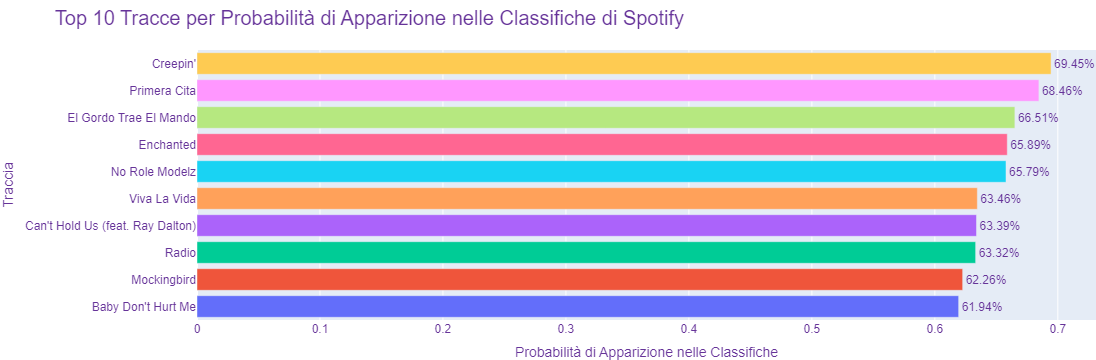

In [146]:
# Creazione del grafico con Plotly Express
fig = px.bar(top_10_df, 
             y='track_name', 
             x='probability_popular', 
             text='probability_popular',
             color='artist(s)_name',  # Colora le barre in base al nome dell'artista
             orientation='h',  # Orientamento orizzontale delle barre
             labels={'probability_popular': 'Probabilità di Apparizione nelle Classifiche', 'track_name': 'Traccia'},
             title='Top 10 Tracce per Probabilità di Apparizione nelle Classifiche di Spotify')

# Personalizzazione ulteriore: disabilita la legenda (dato che la colorazione per artista potrebbe renderla ingombrante)
fig.update_layout(showlegend=False,
                  # Miglioramento dell'aspetto e della leggibilità del grafico
                  title_font_size=20,
                  font=dict(family="Arial, sans-serif", size=12, color="RebeccaPurple"),
                  )

# Migliora la formattazione del testo sui dati per meglio leggere i valori di probabilità
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')

# Aggiustamento del layout del grafico per evitare il taglio del testo
fig.update_layout(margin=dict(t=50, l=0, r=0, b=0))

# Mostra il grafico
fig.show()

Il codice genera un pairplot che aiuta ad esplorare visivamente le relazioni tra varie caratteristiche musicali e di rilascio delle tracce in df_clean, con i punti colorati in base alla chiave musicale. Questo tipo di grafico è particolarmente utile per identificare pattern, correlazioni e potenziali outlier tra le variabili. Ecco una descrizione dettagliata del codice:

sns.pairplot(): Questa funzione di Seaborn crea un grafico pairplot. Per ogni coppia di colonne nel DataFrame, disegna un grafico scatter per le coppie di variabili e un istogramma o un KDE (Kernel Density Estimate) sulla diagonale per mostrare la distribuzione di una singola variabile.

df_clean[['released_year', 'released_month', 'released_day', 'streams', 'bpm', 'key', 'mode', 'danceability_%', 'valence_%', 'energy_%']]: Questa parte del codice seleziona un sottoinsieme di colonne da df_clean da visualizzare nel pairplot. Le colonne selezionate includono anni, mesi e giorni di rilascio, il numero di stream, battiti per minuto (bpm), chiave musicale (key), modalità (mode), e percentuali di danceability, valence e energy. Queste colonne rappresentano le variabili numeriche e categoriche che saranno esplorate nel pairplot.

hue='key': L'argomento hue specifica che il colore dei punti nei grafici scatter dovrebbe variare in base ai valori nella colonna 'key', che rappresenta la chiave musicale delle tracce. Questo aggiunge una dimensione addizionale all'analisi, permettendo di osservare come le relazioni tra le variabili cambiano in base alla chiave musicale.

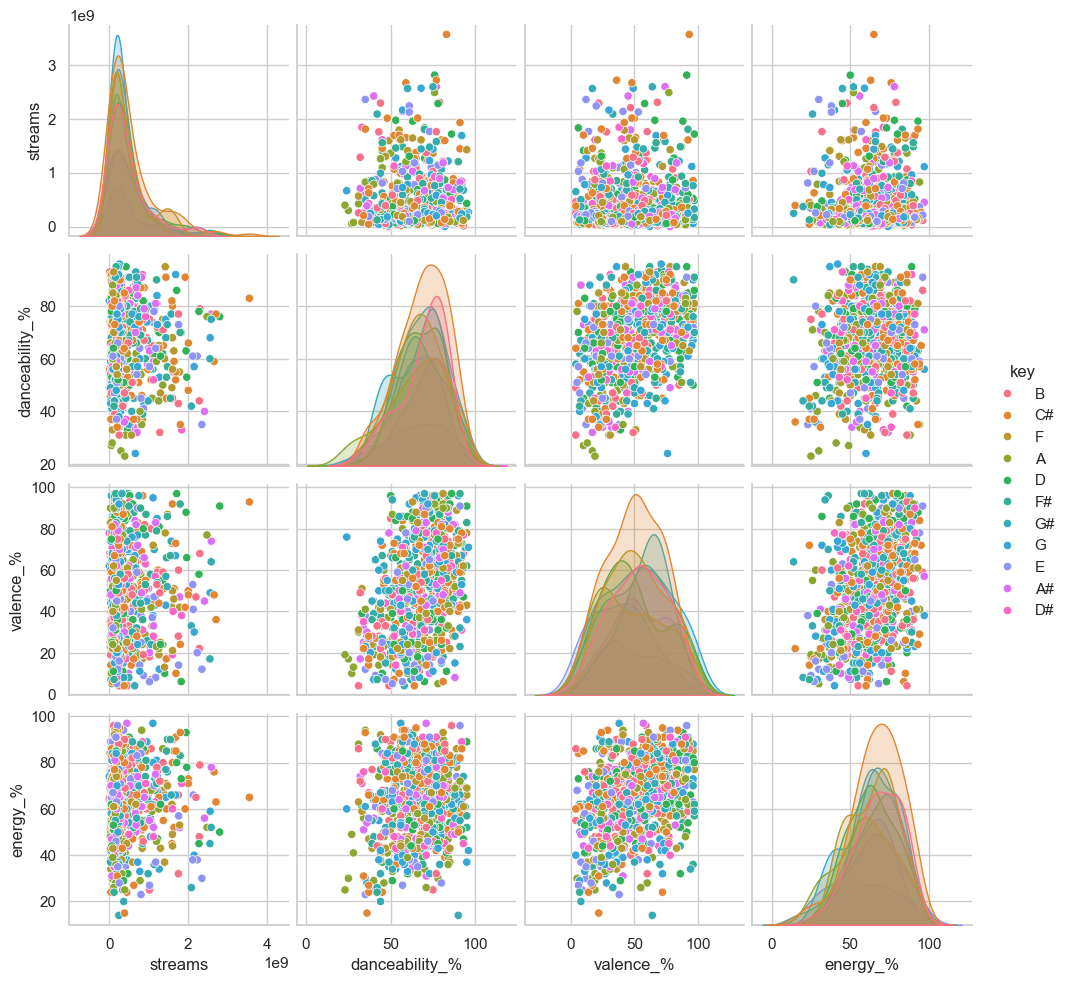

In [38]:
columns_of_interest = [
    'streams', 'key', 'mode', 'danceability_%', 'valence_%', 'energy_%'
]

# Creazione del pairplot con 'key' come variabile di hue per colorare i dati
# in base alla chiave musicale
sns.pairplot(df_clean[columns_of_interest], hue='key')

# Mostra il grafico
plt.show()

Correlazione: Analizza la correlazione tra gli stream e altre variabili numeriche, come bpm (battiti per minuto), danceability_%, valence_%, energy_%, acousticness_%, instrumentalness_%, liveness_%, e speechiness_%. Questo può aiutarti a capire quali caratteristiche delle tracce sono associate a un numero maggiore di stream.

Per analizzare la correlazione tra il numero di stream e altre variabili numeriche come bpm, danceability_%, valence_%, energy_%, acousticness_%, instrumentalness_%, liveness_%, e speechiness_%, possiamo utilizzare il coefficiente di correlazione di Pearson. Questo coefficiente misura la forza e la direzione della relazione lineare tra due variabili su una scala da -1 a 1.

Analisi delle caratteristiche di stile della musica. Correlazioni tra queste variabili e la presenza nelle classifiche

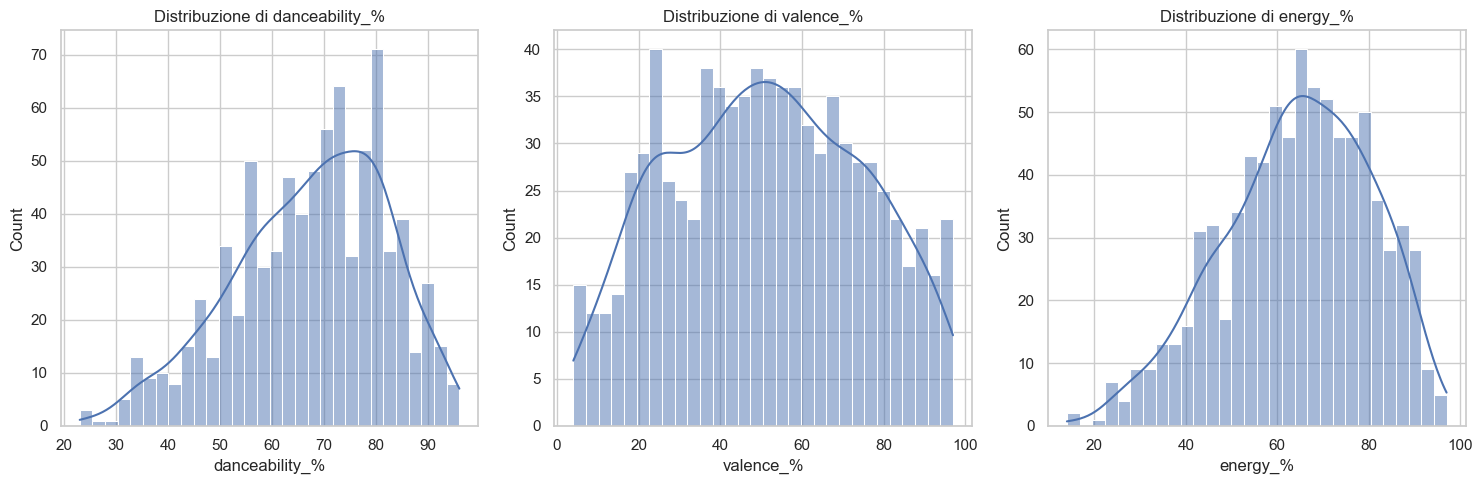

In [39]:
features = ['danceability_%', 'valence_%', 'energy_%']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df_clean[feature], bins=30, kde=True)
    plt.title(f'Distribuzione di {feature}')
plt.tight_layout()
plt.show()

In [40]:
correlations = df_clean[['danceability_%', 'valence_%', 'energy_%', 'in_spotify_charts']].corr()

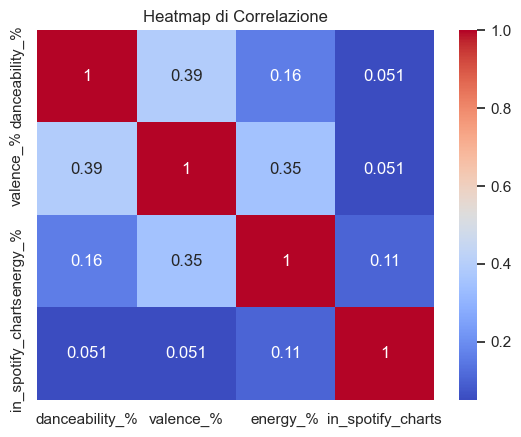

In [41]:
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Heatmap di Correlazione')
plt.show()

Analisi delle caratteristiche sonore della musica. Classificazione delle tracce in base all'acusticità, strumentalità, presenza di elementi live e livello di parlato.

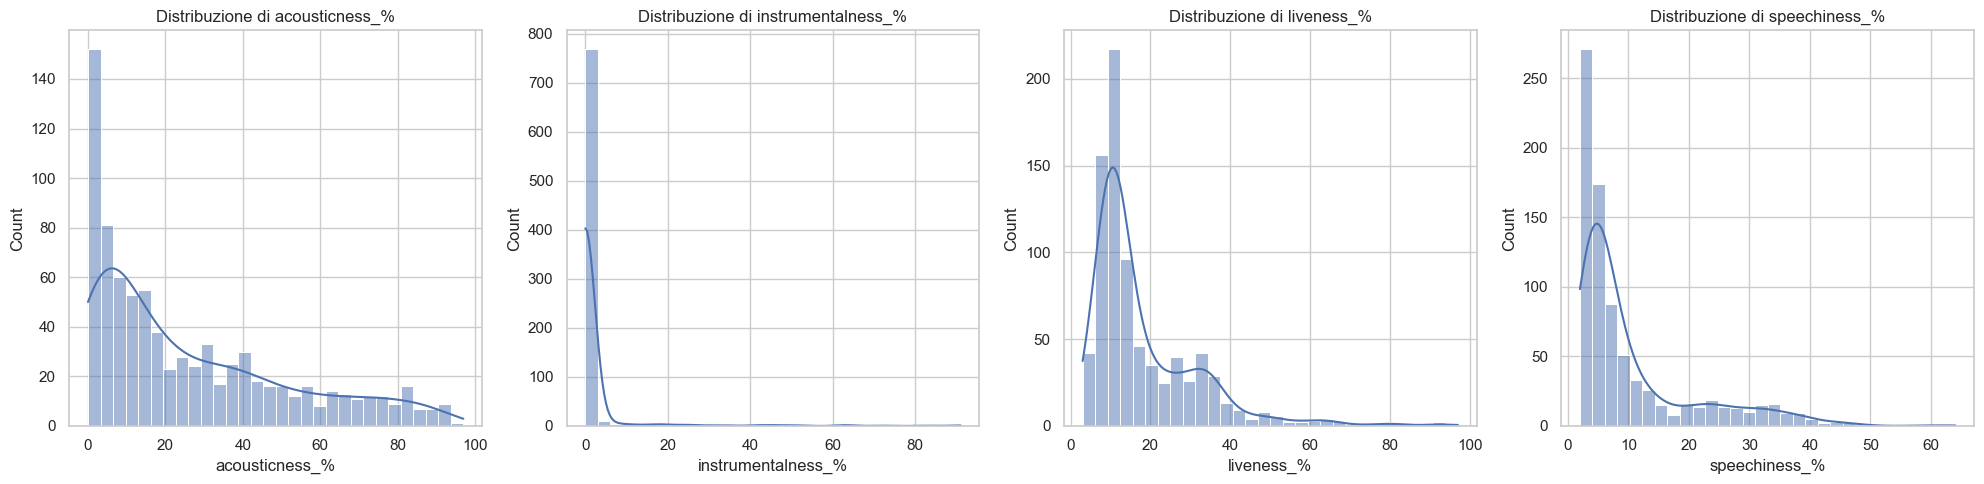

In [42]:
features = ['acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']

# Visualizza la distribuzione delle caratteristiche sonore
plt.figure(figsize=(20, 5))
for i, feature in enumerate(features, 1):
    plt.subplot(1, 4, i)
    sns.histplot(df_clean[feature], kde=True, bins=30)
    plt.title(f'Distribuzione di {feature}')
plt.tight_layout()
plt.show()

In [43]:
def classify_track(row):
    characteristics = []
    if row['acousticness_%'] > 0.5:
        characteristics.append('acousticness')
    if row['instrumentalness_%'] > 0.5:
        characteristics.append('instrumentalness')
    if row['liveness_%'] > 0.5:
        characteristics.append('liveness')
    if row['speechiness_%'] > 0.5:
        characteristics.append('speechiness')
    return ', '.join(characteristics) if characteristics else 'Nessuna caratteristica predominante'

df_clean['Caratteristiche_Sonore'] = df_clean.apply(classify_track, axis=1)

# Visualizza le prime righe per vedere la classificazione
df_clean[['track_name', 'Caratteristiche_Sonore']]

track_name  \
0    Seven (feat. Latto) (Explicit Ver.)   
1                                   LALA   
2                                vampire   
3                           Cruel Summer   
4                         WHERE SHE GOES   
..                                   ...   
948                         My Mind & Me   
949            Bigger Than The Whole Sky   
950                 A Veces (feat. Feid)   
951                        En La De Ella   
952                                Alone   

                                Caratteristiche_Sonore  
0                  acousticness, liveness, speechiness  
1                  acousticness, liveness, speechiness  
2                  acousticness, liveness, speechiness  
3                  acousticness, liveness, speechiness  
4    acousticness, instrumentalness, liveness, spee...  
..                                                 ...  
948                acousticness, liveness, speechiness  
949  acousticness, instrumentalness, liveness, spee...  
950                acousticness, liveness, speechiness  
951                acousticness, liveness, speechiness  
952                acousticness, liveness, speechiness  

[816 rows x 2 columns]

In [44]:
# Analisi della popolarità in base alle caratteristiche sonore
popolarita_per_caratteristica = df_clean.groupby('Caratteristiche_Sonore')['streams'].mean().sort_values(ascending=False)
popolarita_per_caratteristica

Caratteristiche_Sonore
liveness, speechiness                                    5.419570e+08
instrumentalness, liveness, speechiness                  5.363311e+08
acousticness, liveness, speechiness                      4.702405e+08
acousticness, instrumentalness, liveness, speechiness    4.056326e+08
Name: streams, dtype: float64

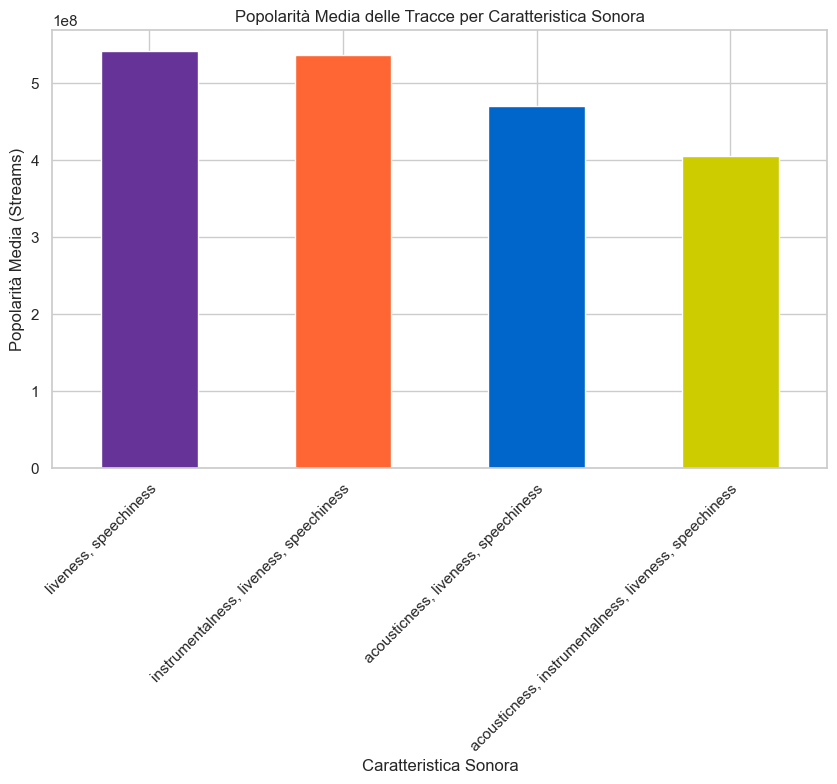

In [45]:

# Definizione della lista di colori
colors = ['#639', '#f63', '#06c', '#cc0', '#f90', '#60c', '#c30', '#0cc', '#c03', '#3c0']

# Creazione del grafico a barre con i colori specificati
ax = popolarita_per_caratteristica.plot(kind='bar', 
                                   title='Popolarità Media delle Tracce per Caratteristica Sonora',
                                   color=colors[:len(popolarita_per_caratteristica)],  # Usa i colori fino al numero di caratteristiche presenti
                                   figsize=(10, 6))  # Regola la dimensione del grafico per una migliore visualizzazione

plt.xlabel('Caratteristica Sonora')
plt.ylabel('Popolarità Media (Streams)')

# Migliora la leggibilità delle etichette sull'asse x
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')  # Ruota le etichette e allinea a destra

# Aggiunge un po' di spazio extra per le etichette
plt.subplots_adjust(bottom=0.15)

# Mostra il grafico
plt.show()

Calcoliamo le correlazioni con il numero di stream

In [46]:
# Verifica della varianza per ogni colonna
variances = df_clean[['acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'streams']].var()

print("Varianza dei dati per colonna:")
print(variances)

Varianza dei dati per colonna:
acousticness_%        6.491084e+02
instrumentalness_%    7.695690e+01
liveness_%            1.836090e+02
speechiness_%         1.045067e+02
streams               2.736616e+17
dtype: float64


In [47]:
# Calcolo delle correlazioni con il numero di stream
correlations_with_streams = df_clean[['acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'streams']].corr()
print("Correlazioni con il numero di stream:")
print(correlations_with_streams['streams'], "\n")

# Se hai anche l'indicatore 'in_charts' per la presenza nelle classifiche, puoi fare lo stesso:
if 'in_charts' in df_clean.columns:
    correlations_with_charts = df_clean[['acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'in_charts']].corr()
    print("Correlazioni con la presenza nelle classifiche:")
    print(correlations_with_charts['in_charts'], "\n")

Correlazioni con il numero di stream:
acousticness_%       -0.005751
instrumentalness_%   -0.033039
liveness_%           -0.056664
speechiness_%        -0.099968
streams               1.000000
Name: streams, dtype: float64 



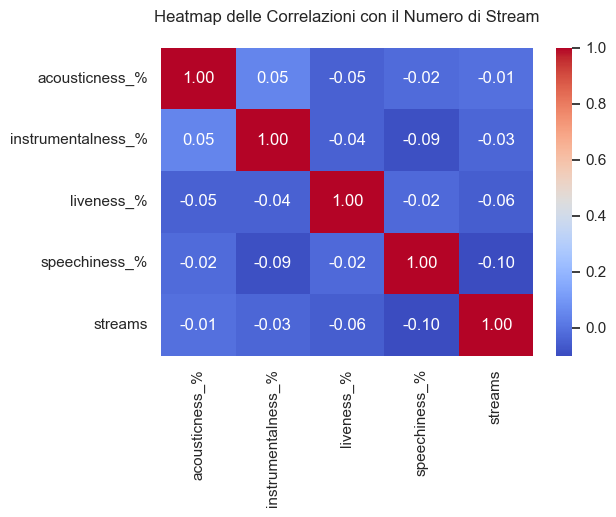

In [48]:
# Heatmap delle correlazioni con il numero di stream
plt.figure(figsize=(6, 4))
sns.heatmap(correlations_with_streams, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap delle Correlazioni con il Numero di Stream\n')
plt.show()

# Se applicabile, heatmap delle correlazioni con la presenza nelle classifiche
if 'in_charts' in df_clean.columns:
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlations_with_charts, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Heatmap delle Correlazioni con la Presenza nelle Classifiche')
    plt.show()

Uso un modello di regressione lineare per prevedere la variabile dipendente y, che in questo caso è 'streams', basandosi su un insieme di variabili indipendenti X che includono 'acousticness_%', 'instrumentalness_%', 'liveness_%', e 'speechiness_%'

In [67]:
# Preparazione delle variabili indipendenti (X) e dipendente (y)
X = df_clean[['bpm','acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%','danceability_%', 'valence_%', 'energy_%']]
y = df_clean['streams']

In [68]:
# Divisione dei dati in set di training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
# Costruzione del modello di regressione lineare
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [70]:
# Predizioni sul set di test
y_pred = model.predict(X_test)

In [71]:
print("Errore quadratico medio (MSE):", mean_squared_error(y_test, y_pred))

Errore quadratico medio (MSE): 2.969502977038016e+17


questo codice cerca di prevedere il numero di stream (popolarità o ascolti) di una traccia musicale in base a caratteristiche quali l'acustica, l'instrumentalness, la vivacità e la presenza di parti parlate. La regressione lineare viene utilizzata per modellare la relazione lineare tra queste caratteristiche e il numero di stream. Dopodiché, valuta l'accuratezza del modello utilizzando metriche statistiche come R^2 e MSE.

Confrontiamo streams con le varie caratteristiche

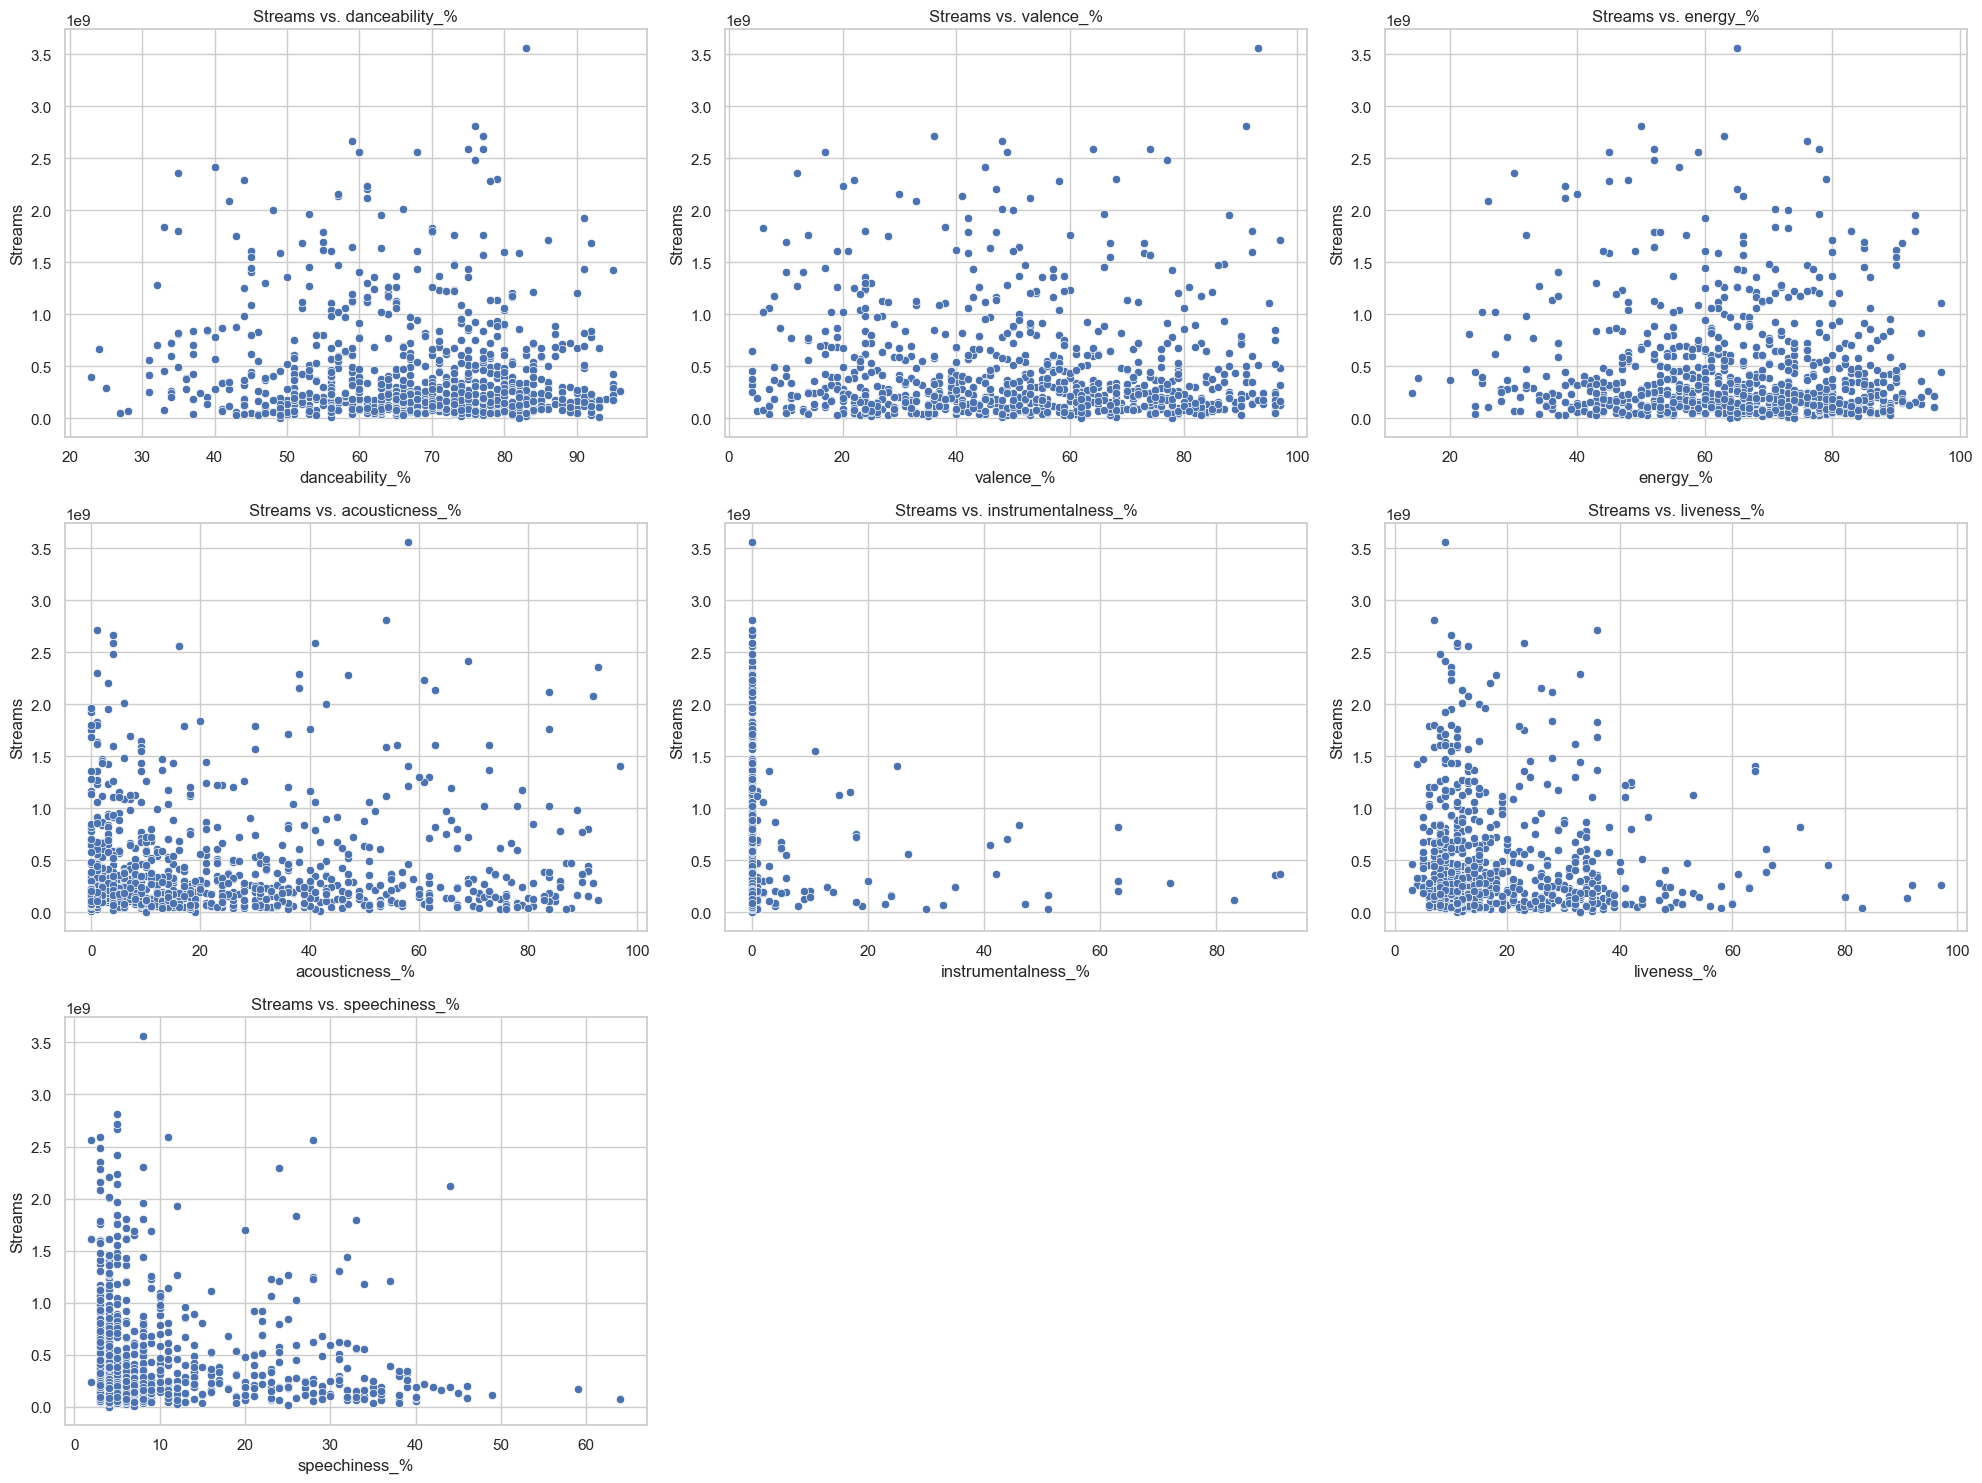

In [54]:
# creeremo scatter plots per gli stream rispetto a ciascuna delle altre variabili numeriche.
# Lista delle variabili per il confronto
variables = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']

# Creazione di scatter plots
plt.figure(figsize=(20, 15))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df_clean[var], y=df_clean['streams'])
    plt.title(f'Streams vs. {var}')
    plt.xlabel(var)
    plt.ylabel('Streams')

plt.tight_layout()
plt.show()

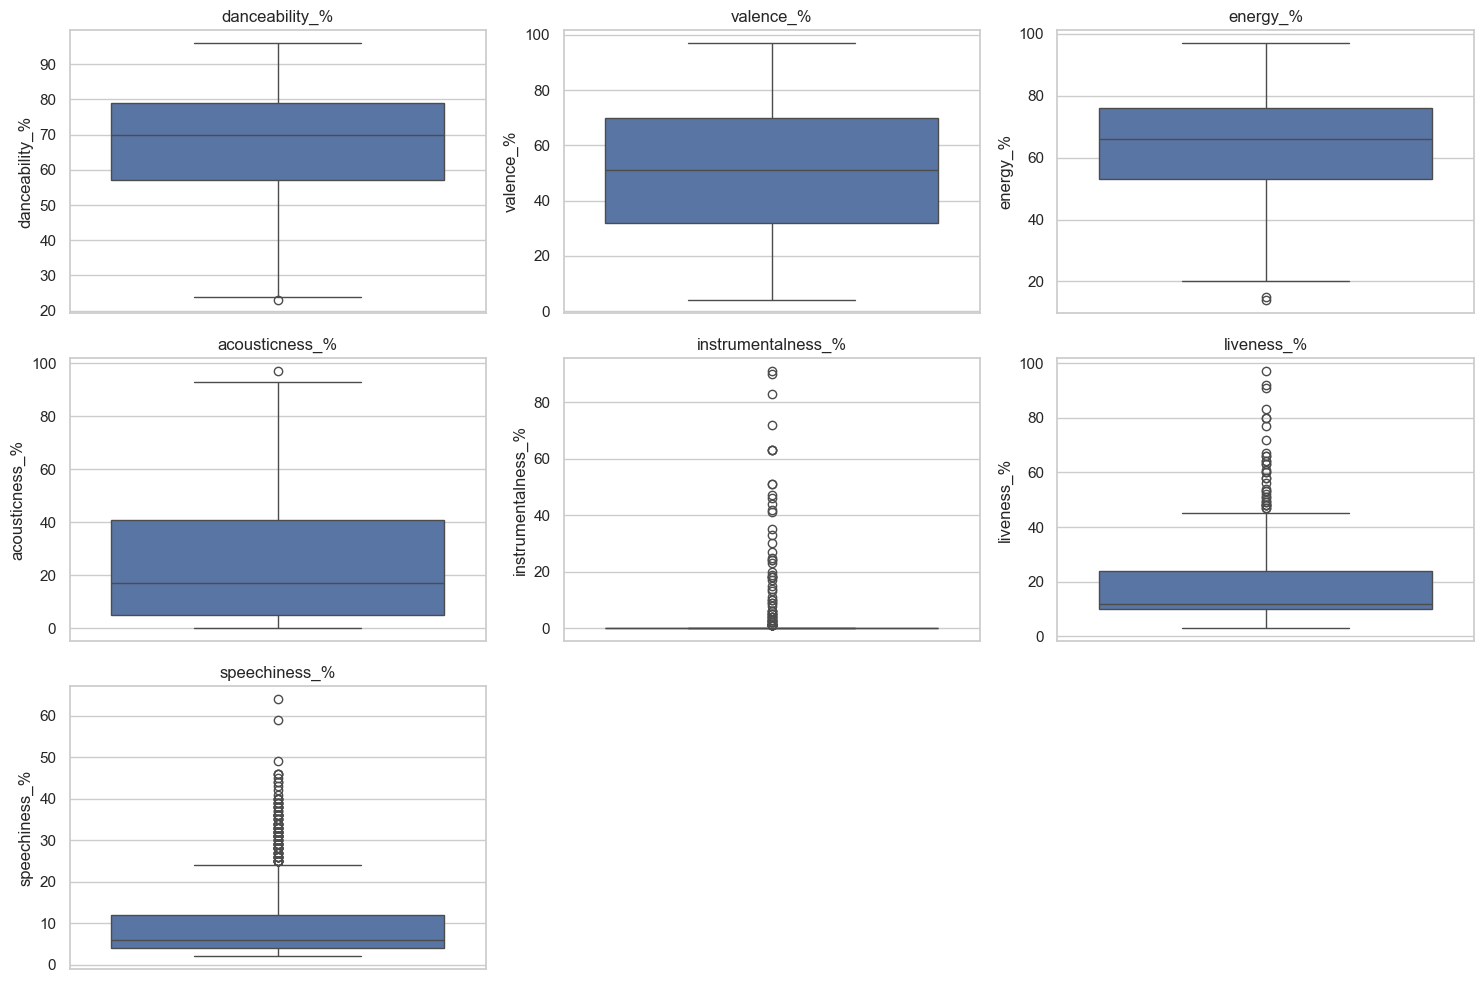

In [55]:
features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df_clean[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()

NAIVE BAYES

In [154]:
#Definizione delle caratteristiche e della variabile target
features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
X = df_clean[features]

soglia = np.percentile(df_clean['in_spotify_playlists'], 50)
y = (df_clean['in_spotify_playlists'] > soglia).astype(int)

In [155]:
# Divisione dei dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
# Addestramento del modello Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

# Calcolo delle probabilità predette
y_pred_proba_nb = model_nb.predict_proba(X_test)[:, 1]

# Conversione delle probabilità in classi binarie usando una soglia, di default 0.5
y_pred_classes_nb = (y_pred_proba_nb >= 0.5).astype(int)

In [157]:
# Ordiniamo gli indici delle tracce in base alla loro probabilità predetta in modo decrescente
sorted_indices = np.argsort(y_pred_classes_nb)[::-1]
top_10_indices = sorted_indices[:10]


# Creiamo un DataFrame per le prime 10 tracce
top_10_df = df_clean.iloc[top_10_indices].copy()
top_10_df['probability_popular'] = y_pred_proba_nb[top_10_indices]

# Ordiniamo il DataFrame in modo crescente rispetto alla probabilità per invertire l'ordine delle barre nel grafico
top_10_df = top_10_df.sort_values(by='probability_popular', ascending=True)

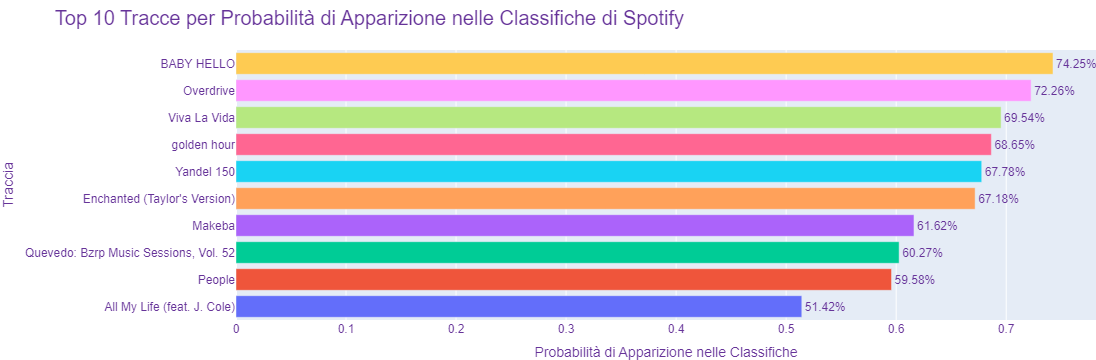

In [158]:
# Creazione del grafico con Plotly Express
fig = px.bar(top_10_df, 
             y='track_name', 
             x='probability_popular', 
             text='probability_popular',
             color='artist(s)_name',  # Colora le barre in base al nome dell'artista
             orientation='h',  # Orientamento orizzontale delle barre
             labels={'probability_popular': 'Probabilità di Apparizione nelle Classifiche', 'track_name': 'Traccia'},
             title='Top 10 Tracce per Probabilità di Apparizione nelle Classifiche di Spotify')

# Personalizzazione ulteriore: disabilita la legenda
fig.update_layout(showlegend=False,
                  title_font_size=20,
                  font=dict(family="Arial, sans-serif", size=12, color="RebeccaPurple"))

# Migliora la formattazione del testo sui dati
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')

# Aggiustamento del layout del grafico
fig.update_layout(margin=dict(t=50, l=0, r=0, b=0))

# Mostra il grafico
fig.show()

In [153]:
# Calcolo delle metriche di classificazione
accuracy_nb = accuracy_score(y_test, y_pred_classes_nb)
precision_nb = precision_score(y_test, y_pred_classes_nb, zero_division=0)
recall_nb = recall_score(y_test, y_pred_classes_nb ,zero_division=0)
f1_nb = f1_score(y_test, y_pred_classes_nb)

print("Naive Bayes - Accuracy:", accuracy_nb)
print("Naive Bayes - Precision:", precision_nb)
print("Naive Bayes - Recall:", recall_nb)
print("Naive Bayes - F1 Score:", f1_nb)

Naive Bayes - Accuracy: 0.6951219512195121
Naive Bayes - Precision: 0.36
Naive Bayes - Recall: 0.20930232558139536
Naive Bayes - F1 Score: 0.2647058823529412
